In [0]:
"""
Random Network Distillation (RND) with Proximal Policy Optimization (PPO) implentation in Tensorflow.
This is a continuous action version which solves the mountain car continuous problem (MountainCarContinuous-v0).
The RND helps learning with curiosity driven exploration.
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym
import time
import itertools

import sklearn.pipeline
import sklearn.preprocessing

# Approximates feature map of an RBF kernel by Monte Carlo approximation of its Fourier transform.
# https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html
from sklearn.kernel_approximation import RBFSampler 

In [0]:
class RunningStats(object):
    # This class which computes global stats is adapted & modified from:
    # https://github.com/openai/baselines/blob/master/baselines/common/running_mean_std.py
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.std = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        
        new_mean = self.mean + delta * batch_count / (self.count + batch_count)
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        self.mean = new_mean
        self.var = new_var
        self.std = np.maximum(np.sqrt(self.var), 1e-6)
        #self.std = np.sqrt(np.maximum(self.var, 1e-2))                            
        self.count = batch_count + self.count

In [0]:
class RND_PPO(object):            
    def __init__(self, tf_operation_level_seed):
        
        self.s = tf.placeholder(tf.float32, [None, S_DIM], 'state')
        self.s_ = tf.placeholder(tf.float32, [None, next_S_DIM], 'state_')
        
        # RND        
        with tf.variable_scope('RND'):
          with tf.variable_scope('target'):
            r_w = tf.random_normal_initializer(seed=tf_operation_level_seed)       
            # Fixed target network encodes state to features        
            # Network randomly initialized once but never trained, params remain fixed, trainable=False  
            self.target_out = tf.layers.dense(self.s_, encode_features, kernel_initializer = r_w, name='target_out', trainable=False)            
            #hidden_layer = tf.layers.dense(self.s_, num_hidden, tf.nn.relu, kernel_initializer = r_w, name='t_hidden', trainable=False)             
            #self.target_out = tf.layers.dense(hidden_layer, encode_features, kernel_initializer = r_w, name='target_out', trainable=False)
            
        # predictor network
          with tf.variable_scope('predictor'):
            #p_w = tf.zeros_initializer()
            p_w = tf.random_normal_initializer(seed=tf_operation_level_seed+1)
            #p_w = tf.glorot_uniform_initializer(seed=tf_operation_level_seed+1)   
            self.predictor_out = tf.layers.dense(self.s_, encode_features, kernel_initializer = p_w, name='predictor_out', trainable=True)            
            #hidden_layer = tf.layers.dense(self.s_, num_hidden, tf.nn.relu, kernel_initializer = p_w, name='p_hidden', trainable=True) 
            #self.predictor_out = tf.layers.dense(hidden_layer, encode_features, kernel_initializer = p_w, name='predictor_out', trainable=True)
            # self.predictor_loss is also the intrinsic reward
            self.predictor_loss = tf.reduce_sum(tf.square(self.target_out - self.predictor_out), axis=1)

        with tf.variable_scope('PPO'):        
          # critic
          with tf.variable_scope('critic'):
            #c_w = tf.zeros_initializer()
            c_w = tf.random_normal_initializer(seed=tf_operation_level_seed+2)
            #c_w = tf.glorot_uniform_initializer(seed=tf_operation_level_seed+2)  
            with tf.variable_scope('critic_extrinsic'):
                # critic network for extrinsic reward
                self.v = tf.layers.dense(self.s, 1, kernel_initializer = c_w, name='val', trainable=True)              
                #hidden_layer = tf.layers.dense(self.s, num_hidden, tf.nn.relu, kernel_initializer = c_w, name='c_e_hidden', trainable=True) 
                #self.v = tf.layers.dense(hidden_layer, 1, kernel_initializer = c_w, name='val', trainable=True)            
                self.tfdc_r = tf.placeholder(tf.float32, [None, 1], 'discounted_r')
                self.advantage = self.tfdc_r - self.v
                self.closs = tf.reduce_mean(tf.square(self.advantage))            
            with tf.variable_scope('critic_intrinsic'):
                # critic network for intrinsic reward           
                self.v_i = tf.layers.dense(self.s, 1, kernel_initializer = c_w, name='val_i', trainable=True)                      
                #hidden_layer = tf.layers.dense(self.s, num_hidden, tf.nn.relu, kernel_initializer = c_w, name='c_i_hidden', trainable=True) 
                #self.v_i = tf.layers.dense(hidden_layer, 1, kernel_initializer = c_w, name='val_i', trainable=True)                                  
                self.tfdc_r_i = tf.placeholder(tf.float32, [None, 1], 'discounted_r_i')
                self.advantage_i = self.tfdc_r_i - self.v_i
                self.closs_i = tf.reduce_mean(tf.square(self.advantage_i))
            with tf.variable_scope('total_critic_loss'):
                self.total_closs = self.closs + self.closs_i
            
          # actor                     
          with tf.variable_scope('actor'):
            pi, pi_params = self._build_anet('pi', trainable=True)
            oldpi, oldpi_params = self._build_anet('oldpi', trainable=False) # trainable=False
            with tf.variable_scope('sample_action'):
              self.sample_op = tf.squeeze(pi.sample(1), axis=0) # choosing action
            with tf.variable_scope('update_oldpi'):
              self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(pi_params, oldpi_params)]
            with tf.variable_scope('surrogate_actor_loss'):
              self.tfa = tf.placeholder(tf.float32, [None, A_DIM], 'action')
              self.tfadv = tf.placeholder(tf.float32, [None, 1], 'advantage')                 
              ratio = pi.prob(self.tfa) / oldpi.prob(self.tfa)
              surr = ratio * self.tfadv
              self.aloss = -tf.reduce_mean(tf.minimum(surr,
                                                      tf.clip_by_value(ratio, 1.-epsilon, 1.+epsilon)*self.tfadv))

            with tf.variable_scope('entropy'):                
              entropy = -tf.reduce_mean(pi.entropy()) # Compute the differential entropy of the multivariate normal.                   
                            
        with tf.variable_scope('total_loss'):
            self.total_loss = tf.reduce_mean(self.predictor_loss) + self.total_closs*c_loss_coeff + self.aloss
        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(TL_LR).minimize(self.total_loss + entropy * ENTROPY_BETA, 
                                                                   global_step=tf.train.get_global_step())
        with tf.variable_scope('sess'):
            self.sess = tf.Session()              
            self.sess.run(tf.global_variables_initializer())
            
    def update(self, s, s_, a, r, r_i, adv):
        if state_ftr == True:
            s = featurize_batch_state(s)        
        self.sess.run(self.update_oldpi_op)        
        [self.sess.run(self.train_op, {self.s: s, self.tfa: a, self.tfadv: adv, self.tfdc_r: r, self.tfdc_r_i: r_i, self.s_: s_}) for _ in range(EPOCH)]
            
    def _build_anet(self, name, trainable):
        # tanh range = [-1,1]
        # softplus range = {0,inf}
        with tf.variable_scope(name):          
            #a_w = tf.zeros_initializer()
            #a_w = tf.random_normal_initializer(seed=tf_operation_level_seed+3) # can't use random for actor, produces nan action
            a_w = tf.glorot_uniform_initializer(seed=tf_operation_level_seed+3)
            mu = tf.layers.dense(self.s, A_DIM, tf.nn.tanh, kernel_initializer = a_w, name='mu', trainable=trainable) 
            sigma = tf.layers.dense(self.s, A_DIM, tf.nn.softplus, kernel_initializer = a_w, name='sigma', trainable=trainable) + 1e-4            
            #hidden_layer = tf.layers.dense(self.s, num_hidden, tf.nn.relu, kernel_initializer = a_w, name='a_hidden', trainable=trainable) 
            #mu = tf.layers.dense(hidden_layer, A_DIM, tf.nn.tanh, kernel_initializer = a_w, name='mu', trainable=trainable) 
            #sigma = tf.layers.dense(hidden_layer, A_DIM, tf.nn.softplus, kernel_initializer = a_w, name='sigma', trainable=trainable) + 1e-4
            norm_dist = tf.distributions.Normal(loc=mu, scale=sigma)
        params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
        return norm_dist, params

    def choose_action(self, s):
        if state_ftr == True:
          s = featurize_state(s)
        s = s[np.newaxis, :]
        a = self.sess.run(self.sample_op, {self.s: s})[0]            
        return np.clip(a, env.action_space.low[0], env.action_space.high[0])

    def get_v(self, s):
        if state_ftr == True:
          s = featurize_state(s)
        if s.ndim < 2: s = s[np.newaxis, :]
        return self.sess.run(self.v, {self.s: s})[0, 0]
      
    def get_v_i(self, s):
        if state_ftr == True:
          s = featurize_state(s)
        if s.ndim < 2: s = s[np.newaxis, :]
        return self.sess.run(self.v_i, {self.s: s})[0, 0]
      
    def intrinsic_r(self, s_):
        return self.sess.run(self.predictor_loss, {self.s_: s_})      
      
    def add_vtarg_and_adv(self, R, done, V, v_s_, gamma, lam):
        # This function is adapted & modified from:
        # https://github.com/openai/baselines/blob/master/baselines/ppo1/pposgd_simple.py
        # Compute target value using TD(lambda) estimator, and advantage with GAE(lambda)
        # last element is only used for last vtarg, but we already zeroed it if last new = 1
        done = np.append(done, 0)
        V_plus = np.append(V, v_s_)
        T = len(R)
        adv = gaelam = np.empty(T, 'float32')
        lastgaelam = 0
        for t in reversed(range(T)):
            nonterminal = 1-done[t+1]        
            delta = R[t] + gamma * V_plus[t+1] * nonterminal - V_plus[t]
            gaelam[t] = lastgaelam = delta + gamma * lam * nonterminal * lastgaelam   
        tdlamret = np.vstack(adv) + V
        return tdlamret, adv # tdlamret is critic_target or Qs         

In [0]:
# pre-train updating of s_ to running_stats_s_ object to prepare for normalization
def state_next_normalize(sample_size, running_stats_s_):
  buffer_s_ = []
  s = env.reset()  
  for i in range(sample_size):
    a = env.action_space.sample()
    s_, r, done, _ = env.step(a)
    buffer_s_.append(s_)    
  running_stats_s_.update(np.array(buffer_s_))

In [0]:
# normalize & clip a running buffer
# used on extrinsic reward (buffer_r), intrinsic reward (buffer_r_i) & next state(s_)
def running_stats_fun(run_stats, buf, clip, clip_state):
    run_stats.update(np.array(buf))
    buf = (np.array(buf) - run_stats.mean) / run_stats.std   
    if clip_state == True:
      buf = np.clip(buf, -clip, clip)
    return buf

In [0]:
start_time = time.time()

EP_MAX = 200 
EP_LEN = 128

sample_size = 10000
n_comp = 100 

ext_r_coeff = 2 # extrinsic reward coefficient
c_loss_coeff = 0.5 # coefficient for total critic loss

s_CLIP = 10 # clip for state buffer
next_s_CLIP = 5 # clip for next state's buffer
r_CLIP = 1 # clip for extrinsic reward, note that intrinsic rewards are not clip.

encode_features = 10000 # number of output for RND predictor's network

# Hyper parameters for computation of TD lambda return and policy advantage using GAE
GAMMA = 0.999 #0.95 #0.95 # discount factor for extrinsic reward
GAMMA_i = 0.99 #0.95 # discount factor for intrinsic reward
lamda = 0.95

# PPO Hyper parameters
TL_LR = 0.0001 #0.001
BATCH = 4 #4 10
EPOCH = 4 #4 10
epsilon = 0.1
ENTROPY_BETA = 0.001#0.001 

num_hidden = 64

np_random_seed = 1
tf_graph_level_seed = np_random_seed + 1
tf_operation_level_seed = tf_graph_level_seed + 1

env = gym.make('MountainCarContinuous-v0')

state_ftr = True # True False
if state_ftr == True:
    S_DIM, next_S_DIM, A_DIM = n_comp*4, 2, 1 # MountainCarContinuous-v0, featurize s only   
else:    
    S_DIM, next_S_DIM, A_DIM = 2, 2, 1 # MountainCarContinuous-v0, not featurize
    
state_next_normal = True # normalize s_ for RND's target & predictor networks

In [0]:
np.random.seed(np_random_seed)

tf.reset_default_graph()
tf.set_random_seed(tf_graph_level_seed) # called before session creation
global_step = tf.Variable(0, name="global_step", trainable=False)
rnd_ppo = RND_PPO(tf_operation_level_seed)

all_steps = [] # stores number of episodic steps for display
all_ep_r = [] # stores raw episodic rewards for display
mv_all_ep_r = [] # store moving average episodic rewards for display

hit_counter = 0 # number of times flag reached by agent

# normalization objects
running_stats_s = RunningStats()
running_stats_s_ = RunningStats()
running_stats_r = RunningStats()
running_stats_r_i = RunningStats()

W0704 15:50:05.533881 140678621886336 deprecation.py:323] From <ipython-input-3-025ef666b892>:13: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0704 15:50:05.916682 140678621886336 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0704 15:50:05.954807 140678621886336 deprecation.py:323] From <ipython-input-3-025ef666b892>:99: Normal.__init__ (from tensorflow.python.ops.distributions.normal) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/p

In [0]:
if state_ftr == True:
# ----------
    # The following code for state featurization is adapted & modified from dennybritz's repository located at:
    # https://github.com/dennybritz/reinforcement-learning/blob/master/PolicyGradient/Continuous%20MountainCar%20Actor%20Critic%20Solution.ipynb
    # Feature Preprocessing: Normalize to zero mean and unit variance
    # We use a few samples from the observation space to do this
    states = np.array([env.observation_space.sample() for x in range(sample_size)]) # pre-trained, states preprocessing
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(states) # Compute the mean and std to be used for later scaling.

    # convert states to a featurizes representation.
    # We use RBF kernels with different variances to cover different parts of the space
    featurizer = sklearn.pipeline.FeatureUnion([ # Concatenates results of multiple transformer objects.       
            ("rbf1", RBFSampler(gamma=5.0, n_components=n_comp)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=n_comp)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=n_comp)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=n_comp))      
            ])
    featurizer.fit(
        scaler.transform(states)) # Perform standardization by centering and scaling

    # state featurization of state(s) only, 
    # not used on s_ for RND's target & predictor networks
    def featurize_state(state):     
        scaled = scaler.transform([state]) # Perform standardization by centering and scaling                    
        featurized = featurizer.transform(scaled) # Transform X separately by each transformer, concatenate results.
        return featurized[0]
# ----------
    def featurize_batch_state(batch_states):
        fs_list = []
        for s in batch_states:
            fs = featurize_state(s)
            fs_list.append(fs)    
        return fs_list   

In [0]:
if state_next_normal == True:
  state_next_normalize(sample_size, running_stats_s_)

done 0 904 67.96394871928882
********** r > 0 ********** 1 1.0
done 1 999 -41.996019369229685
          mv_ep_r 56.96795191043697
done 2 660 69.69695299211344
********** r > 0 ********** 2 0.6666666666666666
          mv_ep_r 58.24085201860462
done 3 763 63.74438558187197
********** r > 0 ********** 3 0.75
          mv_ep_r 58.79120537493135
done 4 480 76.16677375936482
********** r > 0 ********** 4 0.8
          mv_ep_r 60.5287622133747
done 5 661 63.30291048372073
********** r > 0 ********** 5 0.8333333333333334
          mv_ep_r 60.8061770404093
done 6 759 63.03357499094557
********** r > 0 ********** 6 0.8571428571428571
          mv_ep_r 61.02891683546293
done 7 817 54.24585163920308
********** r > 0 ********** 7 0.875
          mv_ep_r 60.350610315836946
done 8 579 60.698388178315966
********** r > 0 ********** 8 0.8888888888888888
          mv_ep_r 60.385388102084846
done 9 999 -71.0662229667864
          mv_ep_r 47.240226995197716
done 10 590 64.39363090152077
********** r > 0 

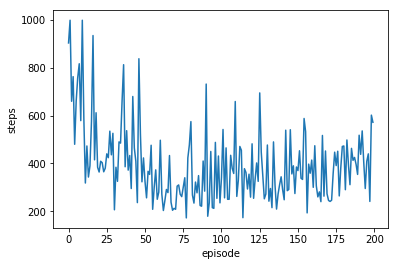

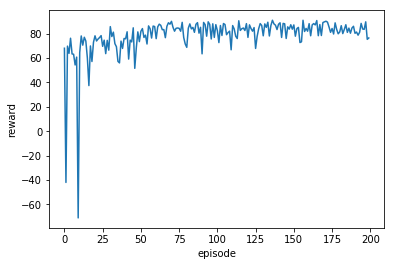

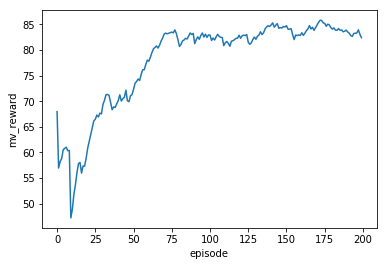

--- 519.7636082172394 seconds ---


In [0]:
for ep in range(EP_MAX):
    s = env.reset()
    buffer_s, buffer_a, buffer_r, buffer_s_, buffer_done, buffer_V, buffer_V_i = [], [], [], [], [], [], []
    ep_r = 0
    steps = 0
    for t in itertools.count(): # each rollout
        #env.render()               
        a = rnd_ppo.choose_action(s)
        s_, r, done, _ = env.step(a)
                
        buffer_s.append(s)
        buffer_a.append(a)
        buffer_r.append(ext_r_coeff * r)    
        buffer_s_.append(s_)
        buffer_done.append(done)                  
        
        v = rnd_ppo.get_v(s)
        buffer_V.append(v)  
        v_i = rnd_ppo.get_v_i(s)
        buffer_V_i.append(v_i)  
        
        s = s_
        ep_r += r
        steps += 1                            
        
        # update rnd_ppo
        if (t+1) % BATCH == 0 or t == EP_LEN-1:
            buffer_s_ = running_stats_fun(running_stats_s_, buffer_s_, s_CLIP, True)          
            if state_next_normal == True:
                buffer_s_ = running_stats_fun(running_stats_s_, buffer_s_, next_s_CLIP, True)                
            buffer_r_i = rnd_ppo.intrinsic_r(buffer_s_)            
            buffer_r = running_stats_fun(running_stats_r, buffer_r, r_CLIP, True)            
            buffer_r_i = running_stats_fun(running_stats_r_i, buffer_r_i, r_CLIP, False)
            
            v_s_ = rnd_ppo.get_v(s_)                                 
            tdlamret, adv = rnd_ppo.add_vtarg_and_adv(np.vstack(buffer_r), 
                                                  np.vstack(buffer_done), 
                                                  np.vstack(buffer_V), 
                                                  v_s_, 
                                                  GAMMA, 
                                                  lamda)
            v_s_i = rnd_ppo.get_v_i(s_)                     
            tdlamret_i, adv_i = rnd_ppo.add_vtarg_and_adv(np.vstack(buffer_r_i),
                                                      np.vstack(buffer_done), 
                                                      np.vstack(buffer_V_i), 
                                                      v_s_i, 
                                                      GAMMA_i, 
                                                      lamda)

            bs, bs_, ba, br, br_i, b_adv = np.vstack(buffer_s), np.vstack(buffer_s_), np.vstack(buffer_a), tdlamret, tdlamret_i, np.vstack(adv + adv_i) # sum advantages
            buffer_s, buffer_a, buffer_r, buffer_s_, buffer_done, buffer_V, buffer_V_i = [], [], [], [], [], [], []
            rnd_ppo.update(bs, bs_, ba, br, br_i, b_adv)
            
        if done:            
            print('done', ep, steps, ep_r) 
            if r > 0:
                hit_counter += 1
                print('********** r > 0 **********', hit_counter, hit_counter / (ep+1))#, ENTROPY_BETA)
                #if ENTROPY_BETA > 0.01:
                #    ENTROPY_BETA = ENTROPY_BETA * 0.9
            break    

    if ep == 0: 
        mv_all_ep_r.append(ep_r)
    else: 
        mv_ep_r = mv_all_ep_r[-1]*0.9 + ep_r*0.1
        print('          mv_ep_r', mv_ep_r)        
        mv_all_ep_r.append(mv_ep_r)       
      
    all_ep_r.append(ep_r)      
    all_steps.append(steps)            
    
print('hit_counter', hit_counter, hit_counter/EP_MAX)    

plt.plot(all_steps)
plt.ylabel("steps")
plt.xlabel("episode")
plt.show()

plt.plot(all_ep_r)
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()

plt.plot(mv_all_ep_r)
plt.ylabel("mv_reward")
plt.xlabel("episode")
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))        